# Color Detection

## load libraries

In [5]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from skimage.io import imread
from colorthief import ColorThief
import os
from tqdm import tqdm

## load image

In [13]:
# load csv file
df = pd.read_csv('../../crawling/contents_merged/batches_with_images/batch_0.csv')

In [14]:
# get amount of non null values
df['Image_URL'].notnull().sum()

6824

In [71]:
# get random 1000 rows
df_sample = df.sample(n=2)
df_sample
df_sample['Image_URL'].iloc[1]

'/media/catalogue/Afghanistan/Postage-stamps/AYO-i.jpg'

# Approach using a built in function

In [74]:
def extract_palette(image_path, num_colors):
    color_thief = ColorThief(image_path)
    palette = color_thief.get_palette(color_count=num_colors)
    return palette

def plot_palette(colors):
    plt.figure(figsize=(12, 2))
    plt.bar(range(len(colors)), [1] * len(colors), color=[tuple(c / 255 for c in color) for color in colors], width=1)
    plt.axis('off')
    plt.show()

def get_image(image_path):
    # url = str(url)

    # if(url != "nan"):

        # url = "https://www.stampworld.com/" + url
        # response = requests.get(url)
        # if response.status_code == 200:
            # image_path = os.path.join("temp", url.split("/")[-1])
            # with open(image_path, 'wb') as f:
                # f.write(response.content)
            num_colors = 5
            colors = extract_palette(image_path, num_colors)
            # plot_palette(colors)

            # convert colors to hex
            colors = [f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}' for color in colors]
            return colors

    #     else:
    #         return None

    # else:
    #     return None

if str(df_sample['Image_Path'].iloc[1]) != "nan":
    colors = get_image("../../crawling" + df_sample['Image_Path'].iloc[1][1:])
    print(colors)
else:
    print("None")

['#d6d8e4', '#2c2c36', '#7b5954', '#84879b', '#c27d52']


In [75]:
str(colors)

"['#d6d8e4', '#2c2c36', '#7b5954', '#84879b', '#c27d52']"

In [60]:
df_sample['Image_URL'].iloc[0]

'/media/catalogue/Afghanistan/Postage-stamps/TC-i.jpg'

In [62]:
df_sample['Image_Path'].iloc[0][1:]

'/images_all_2/Afghanistan/1976/198914/TC-i.jpg'

In [50]:
# download all images in temp folder
for index, row in tqdm(df_sample.iterrows(), total=df_sample.shape[0]):
    url = row['Image_URL']
    url = "https://www.stampworld.com/" + str(url)
    response = requests.get(url)
    if response.status_code == 200:
        image_path = os.path.join("temp", url.split("/")[-1])
        with open(image_path, 'wb') as f:
            f.write(response.content)

100%|██████████| 1000/1000 [13:28<00:00,  1.24it/s]


In [51]:
files = [f for f in os.listdir("temp") if os.path.isfile(os.path.join("temp", f))]

In [52]:
# loop over files and extract palette
all_colors = []
for file in tqdm(files, total=len(files)):
    colors = extract_palette(os.path.join("temp", file), 5)
    all_colors.append(colors)

100%|██████████| 552/552 [01:42<00:00,  5.38it/s]


In [ ]:
# loop over df sample using tqdm
for index, row in tqdm(df_sample.iterrows(), total=df_sample.shape[0]):
    colors = get_image(row['Image_URL'])
    df_sample.loc[index, 'Extracted_Colors'] = str(colors)

# Manual Approach

In [27]:
def get_image(image_url):

    image_url = str(image_url)

    if(image_url != "nan"):

        image_url = "https://www.stampworld.com/" + image_url
        # download image from url
        response = requests.get(image_url)
        image = Image.open(BytesIO(response.content))

        # convert JpegImageFile to numpy array
        image = np.array(image)

        # load image from path ../../image_detection/images_test/test/01.png
        # image = cv2.imread('./test_images/01.png')
        # image = cv2.imread('./test_images/05-1.png')

        # reshape
        pixels_bgr = image.reshape(-1, 3)

        # Convert BGR to RGB
        pixels_rgb = pixels_bgr[:, [2, 1, 0]]

        # Perform PCA to reduce the dimensionality to 2D
        pca = PCA(n_components=2)
        pixels_2d = pca.fit_transform(pixels_rgb)

        # Apply DBSCAN to find dense regions
        dbscan = DBSCAN(eps=1.5, min_samples=10)
        dbscan.fit(pixels_2d)

        # Get the labels for each point
        labels = dbscan.labels_

        # Filter out noise points (label == -1)
        mask = labels != -1
        filtered_pixels_2d = pixels_2d[mask]
        filtered_pixels_rgb = pixels_rgb[mask]

        # kmeans
        optimal_clusters = 3  # Number of main colors you want to find
        kmeans = KMeans(n_clusters=optimal_clusters)
        kmeans.fit(filtered_pixels_rgb)

        # get colors
        # Get the cluster centers (the main colors)
        main_colors = kmeans.cluster_centers_

        # Get the labels for each pixel
        labels = kmeans.labels_

        # Find the cluster with the most pixels
        unique, counts = np.unique(labels, return_counts=True)
        max_cluster = unique[np.argmax(counts)]

        # Filter the pixels belonging to the cluster with the most pixels
        max_cluster_pixels = filtered_pixels_rgb[labels == max_cluster]

        # Create an image showing only the pixels of the largest cluster
        max_cluster_image = np.zeros_like(pixels_rgb)
        max_cluster_image[mask] = main_colors[labels]
        max_cluster_image = max_cluster_image.reshape(image.shape)

        total_pixels = pixels_rgb.shape[0]

        # Calculate the relative counts
        relative_counts = counts / total_pixels

        print('Main colors:')
        print(main_colors)
        print('Relative counts:')
        print(relative_counts)

        # return main colors and relative counts
        return main_colors, relative_counts

    else:
        return None, None


# get main colors
main_colors, relative_counts = get_image(df_sample['Image_URL'].iloc[3])
print(main_colors)

Main colors:
[[180.05406222 170.2192691  181.09725159]
 [238.98057875 238.13277659 240.7953648 ]
 [ 99.14780836  97.33333333 115.40265036]]
Relative counts:
[0.129375   0.60335938 0.03832031]
[[180.05406222 170.2192691  181.09725159]
 [238.98057875 238.13277659 240.7953648 ]
 [ 99.14780836  97.33333333 115.40265036]]


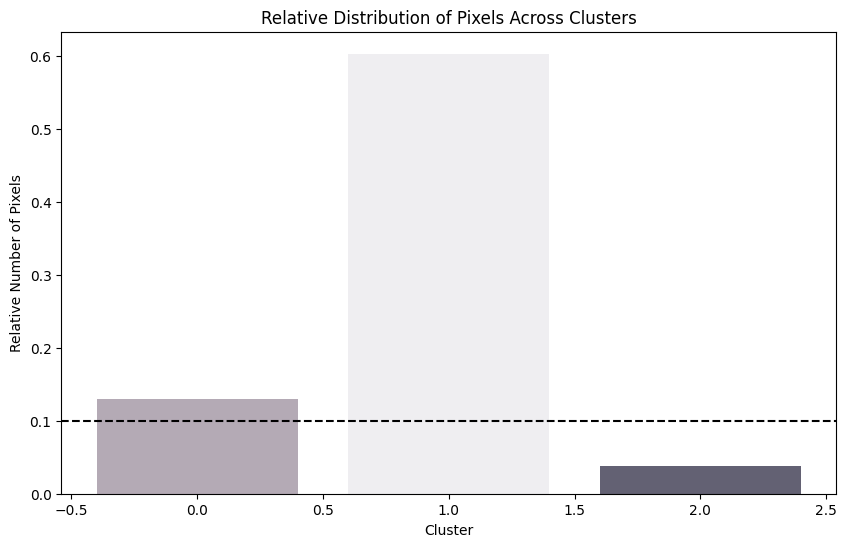

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(range(3), relative_counts, color=main_colors / 255.0)
plt.axhline(y=0.1, color='black', linestyle='--')
plt.xlabel('Cluster')
plt.ylabel('Relative Number of Pixels')
plt.title('Relative Distribution of Pixels Across Clusters')
plt.show()